In [1]:
from scipy.stats import pearsonr
import statsmodels.api
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pickles
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Fonctions de pairgrid personnalisée


def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)


def pairgrid(data_frame):
    g = sns.PairGrid(data_frame, diag_sharey=False)
    g = g.map_offdiag(pairgrid_heatmap, bins=50, color="#880000")
    g = g.map_diag(sns.histplot)


# Fonction de génération de heatmap
def heatmap(table):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(table, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(table, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


# Fonction de calcul de p values de façon systématique
def p_values(input):

    types = input.dtypes

    dataframe = pd.DataFrame(columns=input.columns)

    for (col_a, type_a) in types.iteritems():
        for (col_b, type_b) in types.iteritems():
            if type_a == 'object' and type_b == 'object':
                table = pd.crosstab(input[col_a], input[col_b], normalize=0)
                p_value = chi2_contingency(table)[1]
            elif type_a == 'object':
                anova = statsmodels.formula.api.ols(
                    f'{col_b} ~ {col_a}', data=input).fit()
                table = statsmodels.api.stats.anova_lm(anova)
                p_value = table.at[col_a, 'PR(>F)']
            elif type_b == 'object':
                anova = statsmodels.formula.api.ols(
                    f'{col_a} ~ {col_b}', data=input).fit()
                table = statsmodels.api.stats.anova_lm(anova)
                p_value = table.at[col_b, 'PR(>F)']
            else:
                p_value = pearsonr(input[col_a], input[col_b])[1]
            dataframe.at[col_a, col_b] = 1 if p_value < 0.05 else 0

    return dataframe.fillna(0)


_Commentaire_ : <br>Les graphes peuvent être très denses, pour de l'analyse plus fine il faudrait les mettre en forme différemment. Il suffisent toutefois à apprécier d'un coup d'oeil l'interdépendance des variables. <br>Par ailleurs à date il rest encore quelques nettoyages à faire sur la base de données, au niveau de la labellisation et des jointures notamment.


## Analyse des transactions


In [2]:
transactions = pd.read_pickle('pickles/transactions_all_infos')


In [4]:
transactions_sampled = transactions.sample(frac=0.0001).dropna()
transactions_sampled = transactions_sampled.drop(
    transactions_sampled[transactions_sampled['age'] == 'NONE'].index)
transactions_sampled['age'] = transactions_sampled['age'].astype(int)


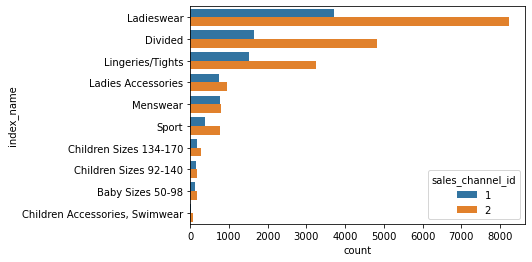

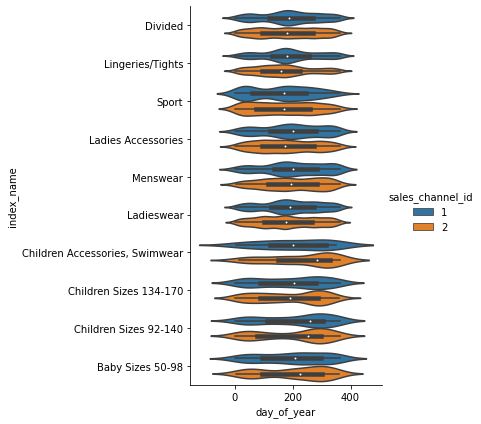

In [5]:
sns.countplot(
    y=transactions_sampled['index_name'],
    hue=transactions_sampled['sales_channel_id'],
    order=transactions_sampled['index_name'].value_counts().index
)
sns.catplot(
    y='index_name',
    x='day_of_year',
    kind='violin',
    hue='sales_channel_id',
    data=transactions_sampled,
    height=6
)


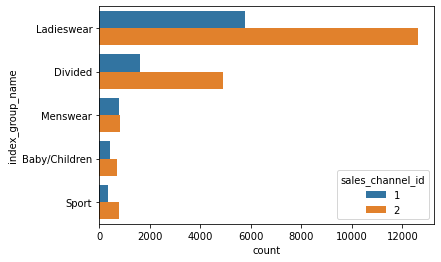

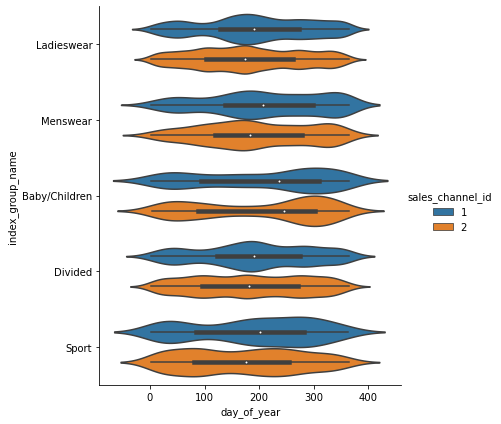

In [34]:
sns.countplot(
    y=transactions_sampled['index_group_name'],
    hue=transactions_sampled['sales_channel_id'],
    order=transactions_sampled['index_group_name'].value_counts().index
)


sns.catplot(
    y='index_group_name',
    x='day_of_year',
    kind='violin',
    hue='sales_channel_id',
    data=transactions_sampled,
    height=6
)


<AxesSubplot:xlabel='count', ylabel='index_group_name'>

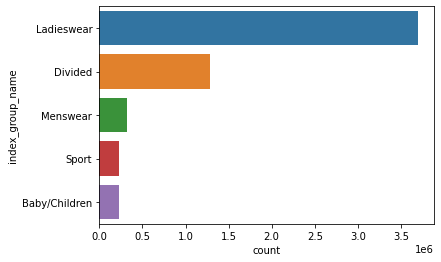

In [30]:
sns.countplot(
    y=transactions['index_group_name'],
    order=transactions['index_group_name'].value_counts().index
)


In [33]:
# Sections : on regarde s'il y a plusieurs index / group par section
sections_group = transactions.groupby('section_name').agg(
    {
        'index_name': "nunique",
        'index_group_name': 'nunique',
        'garment_group_name': 'nunique'
    }
)
sections_group['index_group_name'].value_counts()

# -> Il y a seulement une section qui appartient à deux groupes. On peut donc faire un cat plot


/home/treb/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


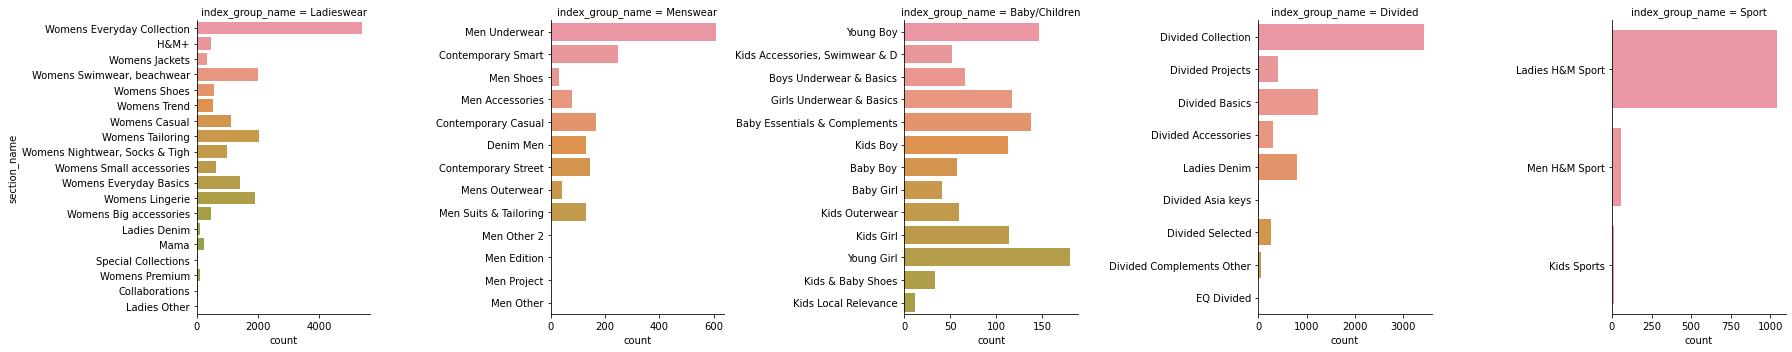

In [37]:

sns.catplot(
    y='section_name',
    kind='count',
    data=transactions_sampled,
    col="index_group_name",
    sharey=False,
    sharex=False
)


/home/treb/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


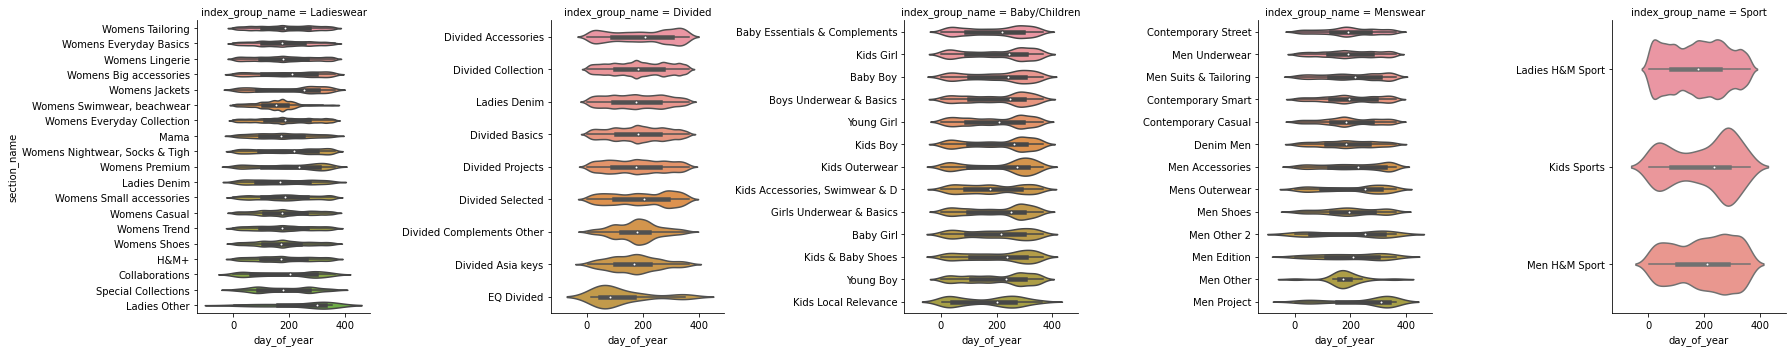

In [56]:

sns.catplot(
    y='section_name',
    x='day_of_year',
    kind='violin',
    data=transactions_sampled,
    col="index_group_name",
    sharey=False,
)


**Observations**

- Prépondérance du canal 2, avec quelques variations selon le type de produit.
- La catégorie Ladieswear et la sous-catégorie "Women Everyday Collection" sont largement majoritaires.
- La répartition des achats dans le temps varie selon le type de produit, mais dans des proportions moindres que le volume.
- Certains types de produit ont toutefois une "signature temporelle" très marquée.


### Analyse selon les caractéristiques du produit


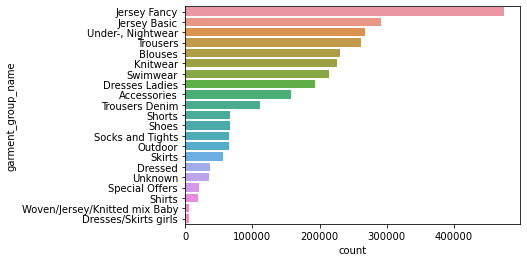

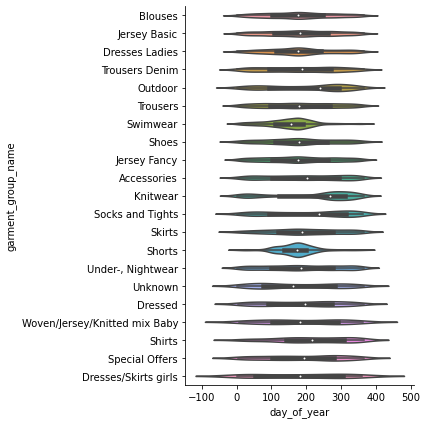

In [45]:
sns.countplot(
    y=transactions['garment_group_name'],
    order=transactions['garment_group_name'].value_counts().index
)

sns.catplot(
    y='garment_group_name',
    x='day_of_year',
    kind='violin',
    data=transactions_sampled,
    height=6
)


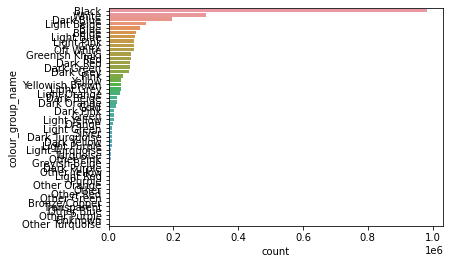

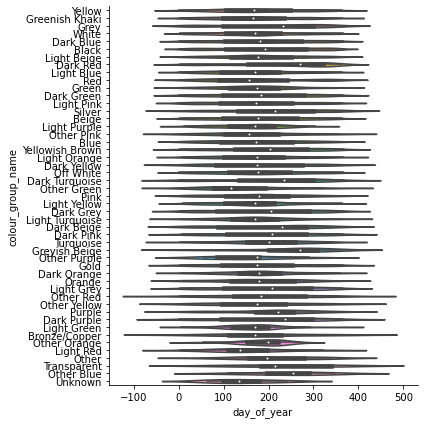

In [41]:
sns.countplot(
    y=transactions['colour_group_name'],
    order=transactions['colour_group_name'].value_counts().index
)

sns.catplot(
    y='colour_group_name',
    x='day_of_year',
    kind='violin',
    data=transactions_sampled,
    height=6
)


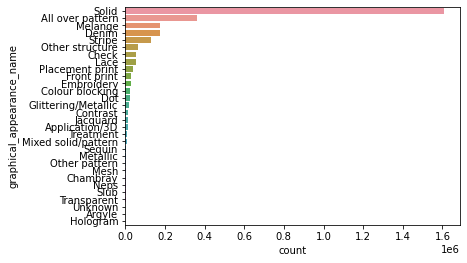

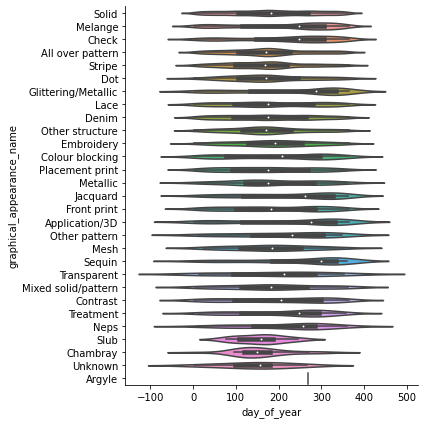

In [42]:
sns.countplot(
    y=transactions['graphical_appearance_name'],
    order=transactions['graphical_appearance_name'].value_counts().index
)

sns.catplot(
    y='graphical_appearance_name',
    x='day_of_year',
    kind='violin',
    data=transactions_sampled,
    height=6
)


**Observations**

- Les articles "Jersey fancy", "Black" et "Solid" sont largement majoritaires.
- Les caractéristiques du produit influent sur les ventes.
- La répartition des achats dans le temps varie selon les caractéristiques du produit, mais dans des proportions moindres que le volume.
- Certaines caractéristiques ont toutefois une "signature temporelle" très marquée.


### Histogrammes et graphes croisés entre les champs


In [6]:
label_encoder = LabelEncoder()

columns_to_encode = [
    'club_member_status',
    'fashion_news_frequency'
]

for column in columns_to_encode:
    transactions_sampled[column] = label_encoder.fit_transform(
        transactions_sampled[column])


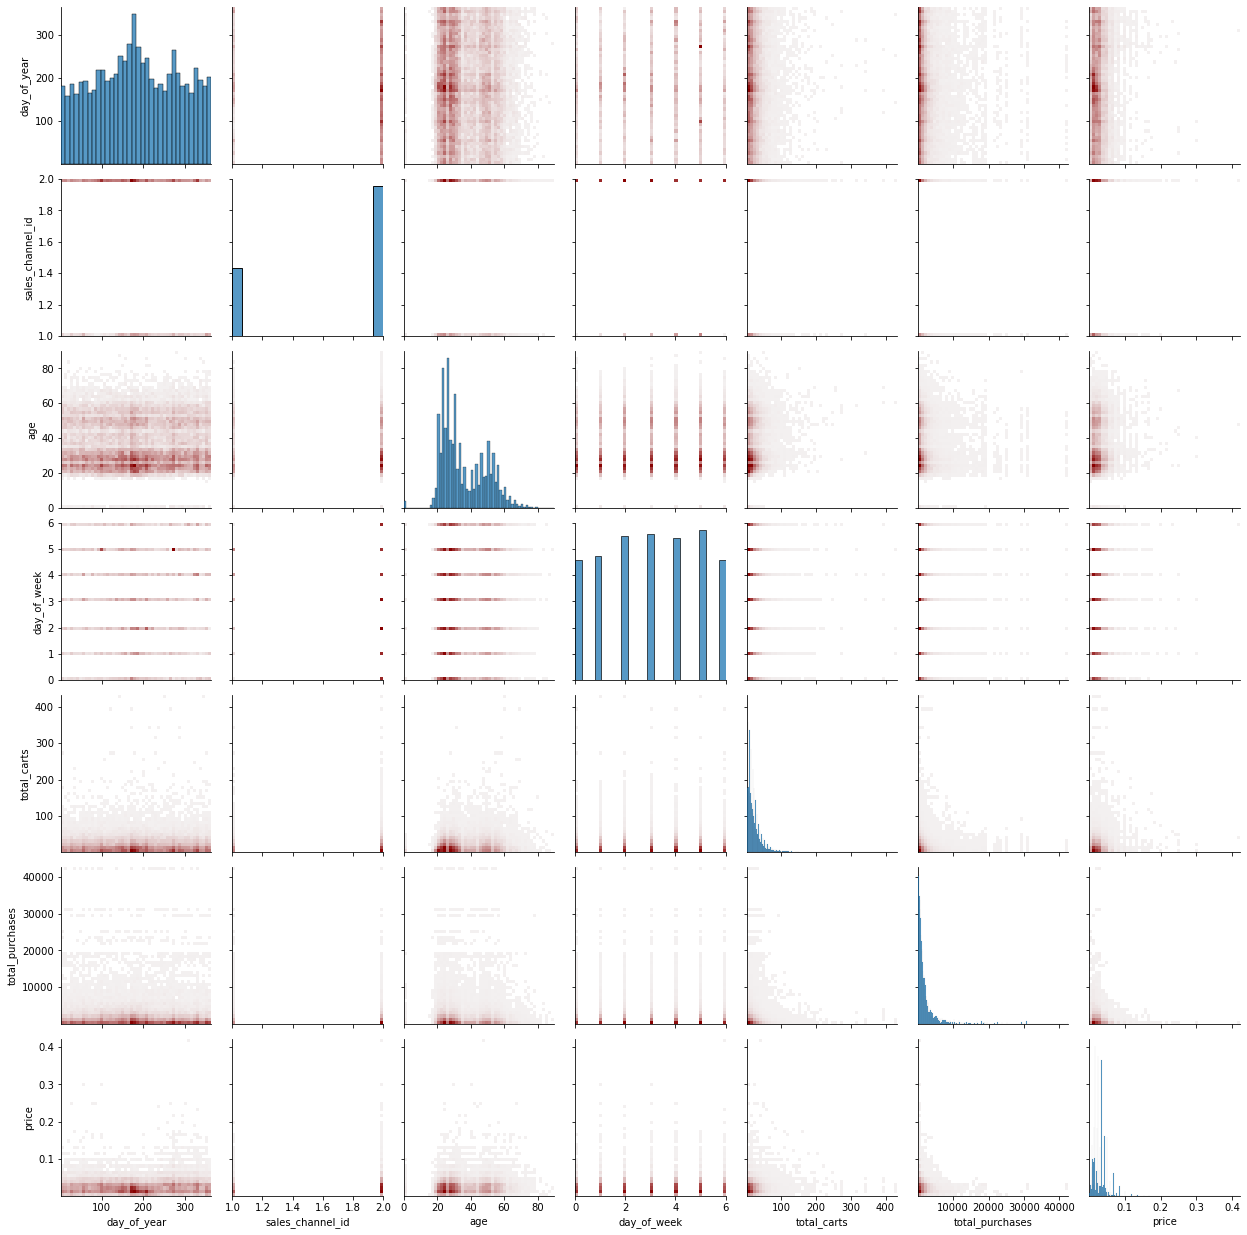

In [16]:
columns_to_analyze = [
    'day_of_year',
    'sales_channel_id',
    'age',
    'day_of_week',
    'total_carts',
    'total_purchases',
    'price',
]

pairgrid(transactions_sampled[columns_to_analyze])


**Observations**

- Le volume des ventes dépend de la période dans une limite du simple au double, avec un minimum en début d'année et un maximum en milieu d'année. (`day_of_year`)
- Deux fois plus de ventes sur le canal 2 que sur le canal 1. (`sales_channel_id`)
- Variations du volume de 20% selon le jour de la semaine. (`day_of_week`)


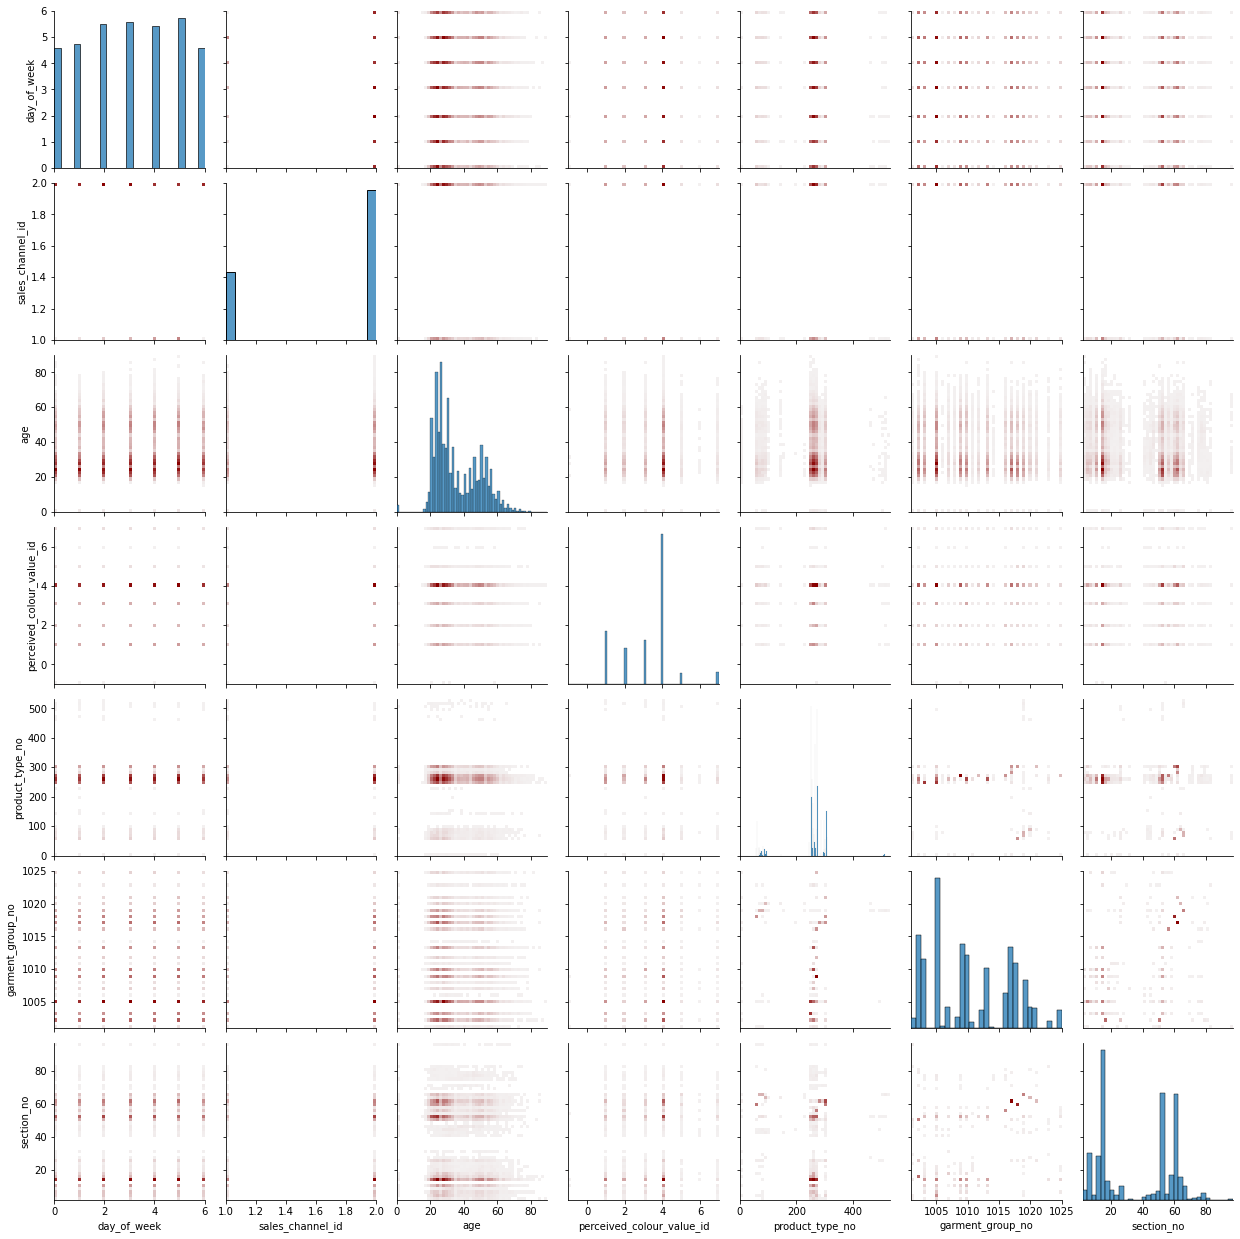

In [53]:
columns_to_analyze = [
    'day_of_week',
    'sales_channel_id',
    'age',
    'perceived_colour_value_id',
    'product_type_no',
    'garment_group_no',
    'section_no'
]

pairgrid(transactions_sampled[columns_to_analyze])


**Observations**

- Le volume de ventes selon les caractéristiques du produit (les 4 colonnes à droite) ne semblent pas varier ni avec l'âge ni avec le jour de la semaine.


### Analyse de corrélation


/tmp/ipykernel_25335/4241145027.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  corr = transactions_sampled.drop(["customer_id", "article_id", "quantity", "prod_name", 'product_code', 'department_no', 'section_no', 'graphical_appearance_no' ], 1).corr()


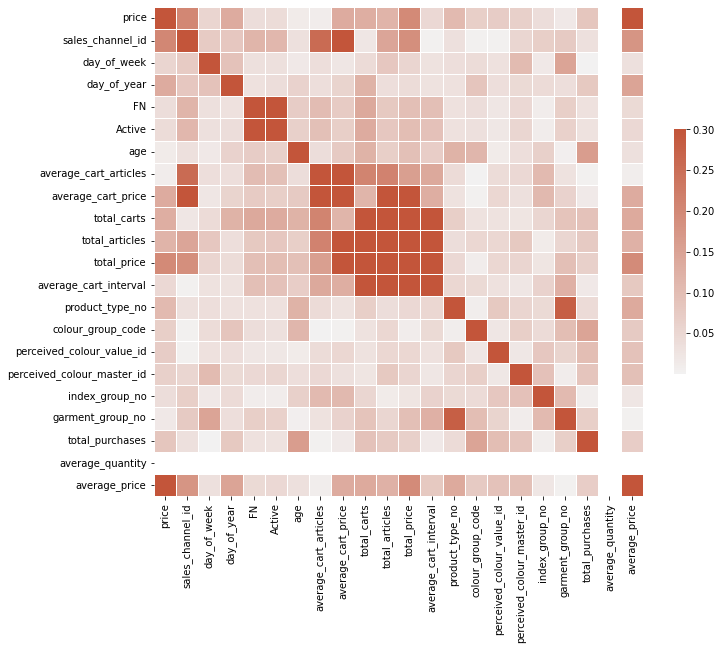

In [38]:
corr = transactions_sampled.drop(["customer_id",
                                  "article_id",
                                  "quantity",
                                  "prod_name",
                                  'product_code',
                                  'department_no',
                                  'section_no',
                                  'graphical_appearance_no'],
                                 1).corr()

heatmap(np.abs(corr))


#### Analyse systématique des p-values
En rouge, les variables pour lesquelles on ne peut pas rejeter l'hypothèse d'indépendance.

/tmp/ipykernel_25335/3736255626.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  transactions_sampled.drop(
/home/treb/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


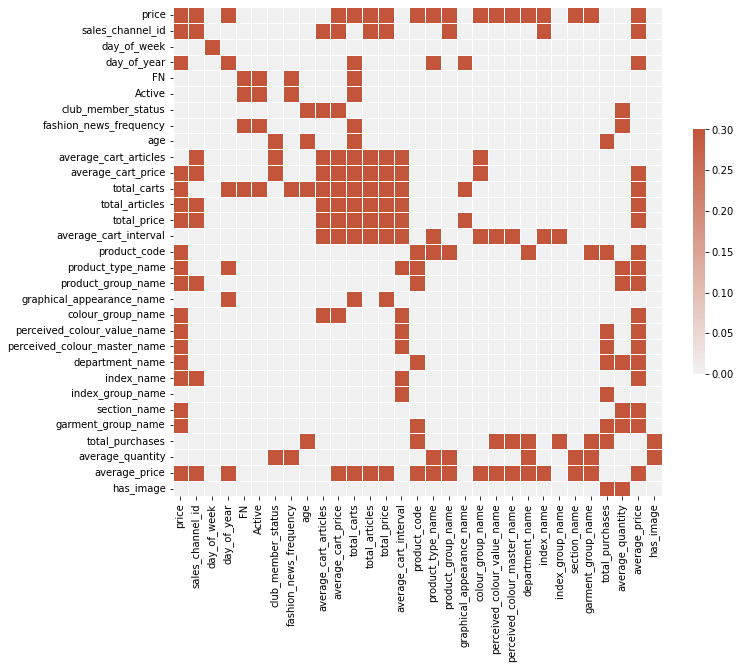

In [48]:
p = p_values(
    transactions_sampled.drop(
        [
            "customer_id",
            "article_id",
            "t_dat",
            "quantity",
            "postal_code",
            "prod_name",
            "product_type_no",
            "graphical_appearance_no",
            "graphical_appearance_no",
            "colour_group_code",
            "perceived_colour_value_id",
            "perceived_colour_master_id",
            "department_no",
            "index_code",
            "index_group_no",
            "section_no",
            "garment_group_no",
            "detail_desc",
            ],
        1))

heatmap(p)


In [34]:
dataframe = pd.DataFrame(columns=transactions_sampled.columns)


,customer_id,article_id,t_dat,price,sales_channel_id,quantity,day_of_week,day_of_year,FN,Active,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,total_purchases,average_quantity,average_price,has_image
bibi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Observations**

- Le nombre d'achats (`total_carts`, `average_cart_articles`) et l'intervalle entre deux paniers (`average_cart_interval`) semblent légèrement corrélés avec l'âge du client.
- La période d'achat du produit (`day_of_year`) semble correllée avec : le canal de vente, les caractéristiques du produit et le nombre total d'achat du produit (`total_purchases`). Cette corrélation n'est toutefois pas très forte.
- Les champs propres au statut du membre (`club_member_status`, `fashion_news_frequency`) sont correlés avec ceux de sont comportement d'achat (`total_carts`, `total_articles`, etc)
- Le prix moyen du panier ainsi que le nombre moyen d'articles (`average_cart_price`, `average_cart_articles`) sont correlés avec le canal de vente de façàon significative.


## Analyse des paniers


In [2]:
carts = pd.read_pickle('pickles/carts_all_infos')


In [3]:
carts_sampled = carts.sample(frac=0.01).dropna()
carts_sampled = carts_sampled.drop(
    carts_sampled[carts_sampled['age'] == 'NONE'].index)
carts_sampled['age'] = carts_sampled['age'].astype(int)
carts_sampled.shape


(91279, 23)

In [4]:
carts_sampled.describe()


,sales_channel_id,total,unique_articles,total_articles_x,day_of_week,day_of_year,day_from_origin,days_from_previous,FN,Active,average_cart_articles,average_cart_price,total_carts,total_articles_y,total_price,average_cart_interval
count,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000,91251.000000
mean,1.600059,0.087556,3.151352,3.151352,3.034641,188.317695,361.480915,40.628399,0.446877,0.440181,3.147945,0.087342,21.328227,65.014509,1.855245,49.946239
std,0.489889,0.094638,3.027608,3.027608,1.915896,102.767139,213.814061,68.706124,0.497173,0.496412,1.806579,0.057412,23.415830,76.561087,2.462889,55.941219
min,1.000000,0.000610,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.003373,1.000000,1.000000,0.003373,0.000000
25%,1.000000,0.033864,1.000000,1.000000,1.000000,103.000000,182.000000,3.000000,0.000000,0.000000,2.000000,0.050819,7.000000,19.000000,0.471746,20.400000
50%,2.000000,0.058271,2.000000,2.000000,3.000000,187.000000,351.000000,15.000000,0.000000,0.000000,2.676471,0.071756,15.000000,42.000000,1.093000,35.250000
75%,2.000000,0.106678,4.000000,4.000000,5.000000,275.000000,549.000000,47.000000,1.000000,1.000000,3.733333,0.105576,27.000000,83.000000,2.281941,59.500000
max,2.000000,2.145153,55.000000,55.000000,6.000000,365.000000,733.000000,729.000000,1.000000,1.000000,35.000000,1.039000,433.000000,1641.000000,49.361407,729.000000


In [6]:
carts_sampled[carts_sampled['days_from_previous']
              != 0]['days_from_previous'].describe()


count    76787.000000
mean        48.281376
std         72.389404
min          1.000000
25%          7.000000
50%         22.000000
75%         57.000000
max        729.000000
Name: days_from_previous, dtype: float64

**Observations**

- Il y a en moyen 3 articles par panier (écart-type de 3)
- Le nombre de panier est bien réparti entre les deux semestres.
- Les "premiers paniers" (= premier panier d'un client sur la période) représentent 15% du total.
- 50% des achats (hors premiers paniers) ont lieu dans les 22 jours de l'achat précédent.


In [23]:
# Encodage des labels
label_encoder = LabelEncoder()

columns_to_encode = [
    'club_member_status',
    'fashion_news_frequency'
]

for column in columns_to_encode:
    carts_sampled[column] = label_encoder.fit_transform(carts_sampled[column])


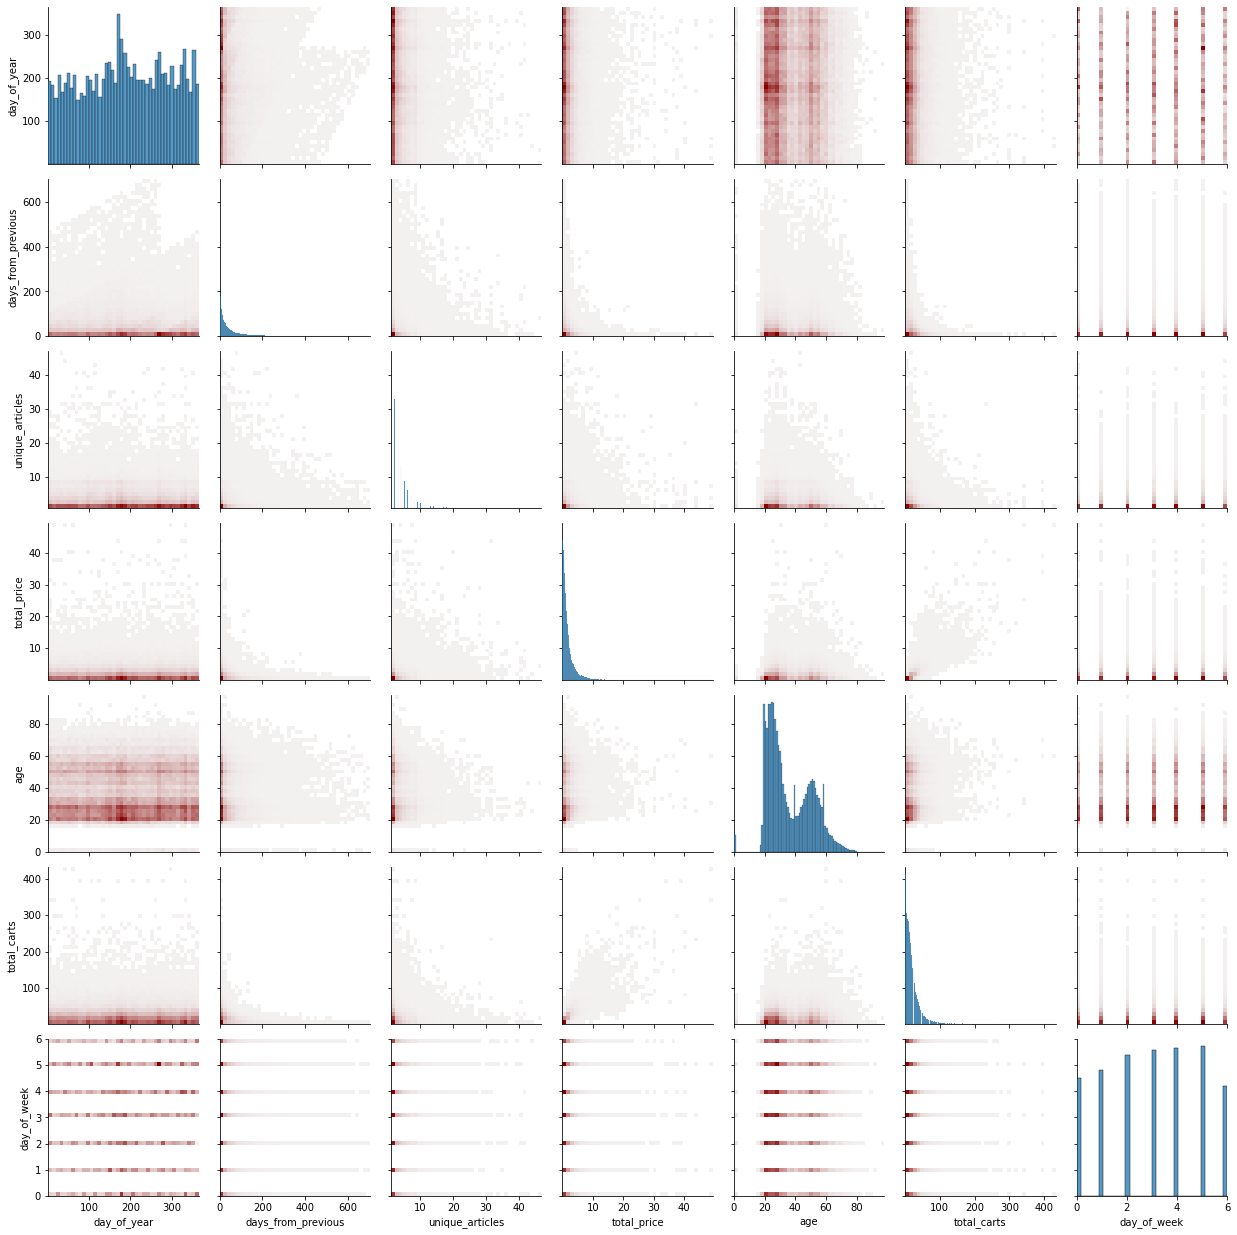

In [7]:
columns_to_analyze = [
    'day_of_year',
    'days_from_previous',
    'unique_articles',
    'total_price',
    'age',
    'total_carts',
    'day_of_week'
]


def pairgrid_heatmap(x, y, **kws):
    cmap = sns.light_palette(kws.pop("color"), as_cmap=True)
    plt.hist2d(x, y, cmap=cmap, cmin=1, **kws)


g = sns.PairGrid(carts_sampled[columns_to_analyze], diag_sharey=False)
g = g.map_offdiag(pairgrid_heatmap, bins=40, color="#880000")
g = g.map_diag(sns.histplot)


**Observations**

- On retrouve les mêmes tendances que pour les transactions uniques.
- La composition, le prix du panier et l'intervalle entre deux paniers (`unique_articles`, `total_price`, `days_from_previous`) semblent correlés avec l'âge.
- Le prix total du panier (`total_price`) et l'intervalle entre deux paniers (`days_from_previous`) semblent correllés.
- Les jours de la semaine enregistrant le plus de ventes (`day_of_week`) semblent varier de façon hétérogène au cours de l'année. (`day_of_year`)


/tmp/ipykernel_10909/1824983539.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  corr = carts_sampled.drop(["customer_id", "t_dat" ], 1).corr()


<AxesSubplot:>

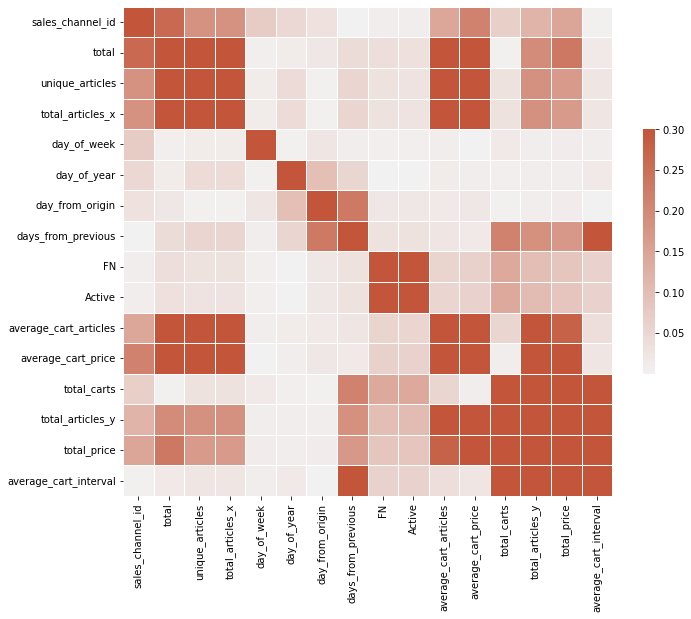

In [48]:

corr = carts_sampled.drop(["customer_id", "t_dat"], 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.abs(corr), cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#### Analyse systématique des p-values
En rouge, les variables pour lesquelles on ne peut pas rejeter l'hypothèse d'indépendance.

In [49]:
carts_sampled.columns

Index(['customer_id', 't_dat', 'sales_channel_id', 'total', 'unique_articles',
       'total_articles_x', 'content', 'day_of_week', 'day_of_year',
       'day_from_origin', 'days_from_previous', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
       'average_cart_articles', 'average_cart_price', 'total_carts',
       'total_articles_y', 'total_price', 'average_cart_interval'],
      dtype='object')

/tmp/ipykernel_28878/3158746622.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  p = p_values(carts_sampled.drop(


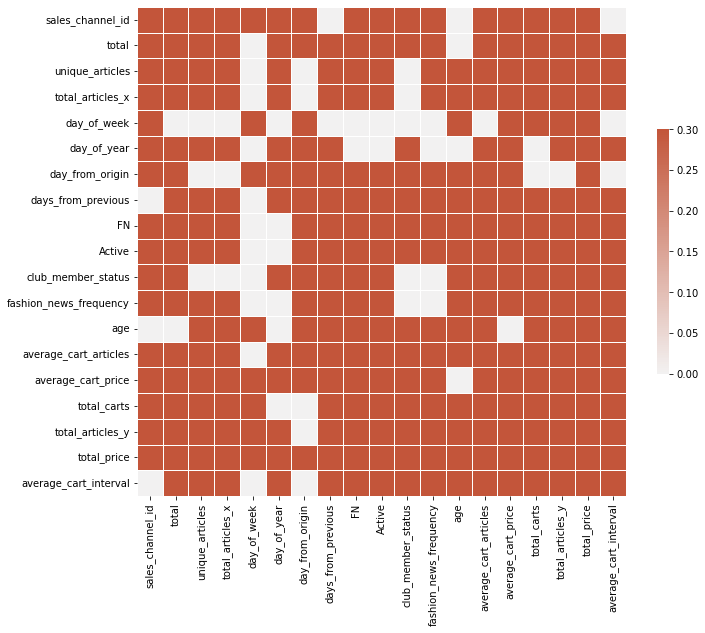

In [5]:
p = p_values(carts_sampled.drop(
    [
        "customer_id", 
        "t_dat", 
        "content",
        "postal_code"
    ], 1))

heatmap(p)


**Observations**

- Corrélation significative entre le contenu du panier (`unique_articles`) et l'intervalle au précédent. (`days_from_previous`)
- Corrélation significative entre le volume d'achat du client (`total_carts`, `total_articles_y`, `total_price`) et l'intervalle au précédent. (`days_from_previous`)
- Le jour d'achat (`day_of_year`) est légèrement corrélé avec le nombre d'articles dans le panier et l'intervalle au précédent. (`days_from_previous`)
- Peu de variables que l'on peut considérer comme indépendantes deux-à-deux.


## Conclusion

- Des corrélations existent entre les caractéristiques des clients, les caractéristiques des produits et le volume des ventes.
- Les caractéristiques du produit ont une certain influence sur la date d'achat.
- Les caractéristiques du client semblent avoir peu d'influence sur la date d'achat
- Corrélation significative entre le contenu du panier et l'intervalle au précédent.

-> Une analyse statique (ne tenant pas compmte des aspects temporels) pourra peut-être avoir quelques résultats mais sera très probablement limitée, au vu des relations observées entre les différentes informations.

**-> À travers l'étude de l'intervalle entre les paniers, on confirme qu'une analyse temporelle serait pertinente.** D'autres intervalles temporels pourrait être étudiés (= entre deux achats d'un même produit, etc) avant ou après l'élaboration d'un premier modèle.
